### Cell A — Imports & Config

In [1]:
# === Cell A — Imports, paths, reproducibility ===
import os, random, time
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
import sys
from pathlib import Path
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights

# Optional: avoid some multiprocessing headaches
try:
    import torch.multiprocessing as mp
    mp.set_start_method("spawn", force=True)
    torch.multiprocessing.set_sharing_strategy("file_system")
except Exception:
    pass

# Paths
root = Path("..").resolve()
if str(root) not in sys.path:
    sys.path.append(str(root))
if str(root / "src") not in sys.path:
    sys.path.append(str(root / "src"))

print("Root added to PYTHONPATH:", root)

data_dir = root / "data" / "wlasl_preprocessed"
roi_manifest = data_dir / "manifest_nslt2000_roi_full_resplit_70_15_15_min7.csv"
assert roi_manifest.exists(), f"Missing manifest: {roi_manifest}"

ckpt_dir = root / "checkpoints"
ckpt_dir.mkdir(exist_ok=True)

# Device & seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

print("Device:", device)
print("Manifest:", roi_manifest)


Root added to PYTHONPATH: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL
Device: cuda
Manifest: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/data/wlasl_preprocessed/manifest_nslt2000_roi_full_resplit_70_15_15_min7.csv


### Cell B — Load manifest, dataset, Kinetics normalization, loaders

In [2]:
# === Cell B — Dataset, Kinetics normalization, DataLoaders ===
from src.data.wlasl_ds import WLASLDataset
import src.data.wlasl_ds as wds_mod

df = pd.read_csv(roi_manifest)
assert {"path", "gloss", "label_new", "split"}.issubset(df.columns), df.columns

# 🔧 Make sure the column used by WLASLDataset ("label") is the new contiguous one
df = df.copy()
df["label"] = df["label_new"]

num_classes = df["label"].nunique()
print("num_classes:", num_classes)
print("split counts:", df["split"].value_counts().to_dict())

# Kinetics-style normalization (matches K400 pretraining)
def kinetics_normalize(x):
    # x: [T,C,H,W] float32 in [0,1]
    mean = torch.tensor((0.432, 0.394, 0.376), dtype=x.dtype, device=x.device)[None,:,None,None]
    std  = torch.tensor((0.228, 0.221, 0.223), dtype=x.dtype, device=x.device)[None,:,None,None]
    return (x - mean) / std

# Monkeypatch the dataset's _normalize
wds_mod._normalize = kinetics_normalize

# train/val/test splits
train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)
test_df  = df[df["split"] == "test"].reset_index(drop=True)


CLIP_LEN = 32
STRIDE   = 2
BATCH    = 8
NUM_WORKERS = 4

train_ds = WLASLDataset(train_df, clip_len=CLIP_LEN, stride=STRIDE, train=True)
val_ds   = WLASLDataset(val_df,   clip_len=CLIP_LEN, stride=STRIDE, train=False)
test_ds  = WLASLDataset(test_df,  clip_len=CLIP_LEN, stride=STRIDE, train=False)

# Optional weighted sampler for class imbalance
use_weighted_sampler = True

if use_weighted_sampler:
    counts = train_df["label_new"].value_counts().to_dict()
    weights = train_df["label_new"].map(lambda y: 1.0 / counts[y]).values.astype(np.float32)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    train_loader = DataLoader(
        train_ds, batch_size=BATCH, sampler=sampler,
        num_workers=NUM_WORKERS, pin_memory=True
    )
else:
    train_loader = DataLoader(
        train_ds, batch_size=BATCH, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=True
    )

val_loader  = DataLoader(val_ds,  batch_size=BATCH, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

print(f"Splits | train={len(train_ds)} val={len(val_ds)} test={len(test_ds)}")
print("train label range:", train_df["label"].min(), "→", train_df["label"].max())
print("val label range:",   val_df["label"].min(),   "→", val_df["label"].max())
print("test label range:",  test_df["label"].min(),  "→", test_df["label"].max())
print("num_classes:", num_classes)


num_classes: 647
split counts: {'train': 3286, 'test': 1350, 'val': 656}
Splits | train=3286 val=656 test=1350
train label range: 0 → 646
val label range: 0 → 646
test label range: 0 → 646
num_classes: 647


#### Cell C — R(2+1)D-18 model (Kinetics-400)

In [3]:
# === Cell C — R(2+1)D-18 Kinetics-400 model ===

class R2Plus1D18WithPermute(nn.Module):
    """Wrap r2plus1d_18 to accept [B, T, C, H, W] and permute internally."""
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        weights = R2Plus1D_18_Weights.KINETICS400_V1 if pretrained else None
        self.backbone = r2plus1d_18(weights=weights)
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_feats, num_classes)

    def forward(self, x):  # x: [B, T, C, H, W]
        x = x.permute(0, 2, 1, 3, 4).contiguous()  # -> [B, C, T, H, W]
        return self.backbone(x)

torch.set_float32_matmul_precision('high')

model = R2Plus1D18WithPermute(num_classes=num_classes, pretrained=True).to(device)
print("Model: R(2+1)D-18 K400")


Model: R(2+1)D-18 K400


#### Cell D — Optimizer, AMP, training utilities

In [4]:
# === Cell D — Optimizer, AMP, helpers ===
from torch.optim import AdamW
from torch.amp import GradScaler

EPOCHS = 20
LR     = 1e-4
WD     = 1e-5
AMP_ON = True

opt    = AdamW(model.parameters(), lr=LR, weight_decay=WD)
scaler = GradScaler(enabled=AMP_ON)
criterion = nn.CrossEntropyLoss(label_smoothing=0.0)  # or 0.1 if you like
best_val_acc = -1.0

def top1_acc(logits, y):
    with torch.no_grad():
        return (logits.argmax(1) == y).float().mean().item()

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss = 0.0
    total_acc  = 0.0
    total_n    = 0

    if train:
        opt.zero_grad(set_to_none=True)

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.amp.autocast(device_type=device.type, enabled=AMP_ON):
            logits = model(x)
            loss = F.cross_entropy(logits, y)

        if train:
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            opt.zero_grad(set_to_none=True)

        with torch.no_grad():
            bs = x.size(0)
            total_loss += loss.item() * bs
            total_acc  += top1_acc(logits, y) * bs
            total_n    += bs

    return total_loss / total_n, total_acc / total_n


#### Cell E — Training loop & checkpoint

In [5]:
# === Cell E — Training loop & checkpoint (updated to save prefixed filenames) ===
from pathlib import Path
import time

best_val_acc = -1.0
nb_stem = Path("06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18-full.ipynb").stem
nb_prefix = str(nb_stem).replace(' ', '_')
if 'run_tag' in globals():
    run_id = f"{nb_prefix}_{run_tag}"
else:
    run_id = f"{nb_prefix}_{time.strftime('%Y%m%dT%H%M%S')}"

# canonical filenames (full checkpoint + plain state dict)
full_best = ckpt_dir / f"{run_id}_best_full.pt"
state_best = ckpt_dir / f"{run_id}_best_state.pt"

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        # save both a full checkpoint and a plain model state_dict, both prefixed with the notebook/run id
        state = {
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optim_state': opt.state_dict() if 'opt' in globals() else None,
            'scaler_state': scaler.state_dict() if 'scaler' in globals() else None,
            'best_val_acc': best_val_acc,
        }
        torch.save(state, full_best)
        torch.save(model.state_dict(), state_best)
        print(f"  ➜ New best val acc={best_val_acc:.3f} — saved: {full_best}, {state_best}")


Epoch 01/20 | train loss 6.5294 acc 0.031 | val loss 6.5955 acc 0.011
  ➜ New best val acc=0.011 — saved: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18-full_20251117T212836_best_full.pt, /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18-full_20251117T212836_best_state.pt
  ➜ New best val acc=0.011 — saved: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18-full_20251117T212836_best_full.pt, /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18-full_20251117T212836_best_state.pt
Epoch 02/20 | train loss 5.8656 acc 0.094 | val loss 6.0925 acc 0.026
Epoch 02/20 | train loss 5.8656 acc 0.094 | val loss 6.0925 acc 0.026
  ➜ New best val acc=0.026 — saved: /home/falasoul/notebooks/USD/A

#### Cell F — Test evaluation

In [6]:
### DEPRECATED — old test-evaluation cell

# This cell is deprecated and left only for reference. It references a variable `best_path` that may not be defined in the current notebook run and can raise an error.

# Please use the newer evaluation cell at the end of this notebook titled "Evaluation & Reports — train/val curves, confusion matrix, per-class accuracy, and test summary" which:

# - finds the correct checkpoint using the notebook-prefixed run id,
# - extracts nested model state dicts from full checkpoints or plain state dicts,
# - attempts robust loading (remapping common prefixes and partial intersection fallback),
# - evaluates the test set and saves confusion matrix, per-class accuracy CSV, classification reports, predictions CSV, and a JSON/TXT test summary (all filenames prefixed by the notebook stem and run id).

# If you want to run a single quick test with a known checkpoint path, set `best_path = Path('checkpoints/your_checkpoint.pt')` in a small code cell and run that, or run the final evaluation cell which automates everything.


In [7]:
import os
os.getpid()

2785598

### Evaluation & Reports — train/val curves, confusion matrix, per-class accuracy, and test summary

This cell will (1) attempt to find the best checkpoint saved by the training loop (prefixed with the notebook stem/run id), (2) run evaluation on the test set, (3) compute a normalized confusion matrix using only labels present in predictions/targets, (4) compute per-class accuracy and classification report and save them, and (5) write a ChatGPT-friendly JSON/TXT summary. All saved filenames are prefixed with the notebook stem and run id to avoid generic names.


No history found; skipping curves.
Loading checkpoint: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18-full_20251117T212836_best_state.pt


Evaluating test set: 100%|██████████| 169/169 [00:13<00:00, 12.65it/s]



Test Top-1 accuracy: 0.2230 (N=1350)


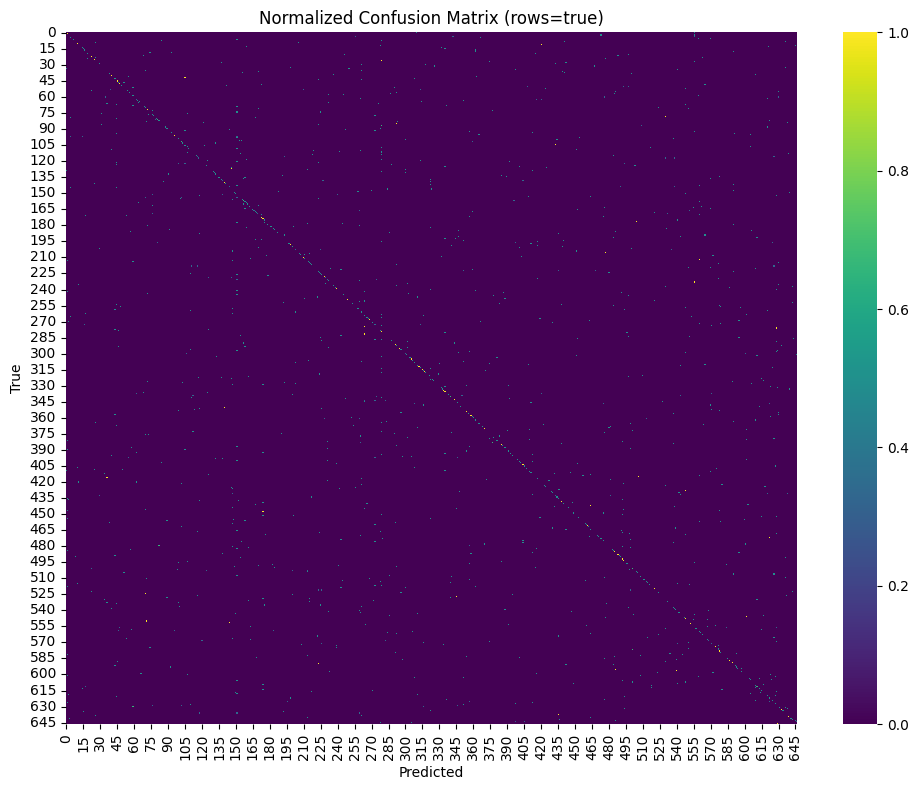

,label,gloss,accuracy,support
0,25,apple,1.0,3
1,492,score,1.0,3
2,174,delay,1.0,3
3,22,animal,1.0,2
4,574,thirsty,1.0,2
5,45,balance,1.0,2
6,47,ball,1.0,2
7,578,tie,1.0,2
8,40,baby,1.0,2
9,438,possible,1.0,2



Saved classification report (json & txt) at: reports/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18-full_20251117T212836_classification_report.json reports/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18-full_20251117T212836_classification_report.txt

Saved test report JSON and TXT to reports/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18-full_20251117T212836_test_report.json reports/06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18-full_20251117T212836_test_report.txt


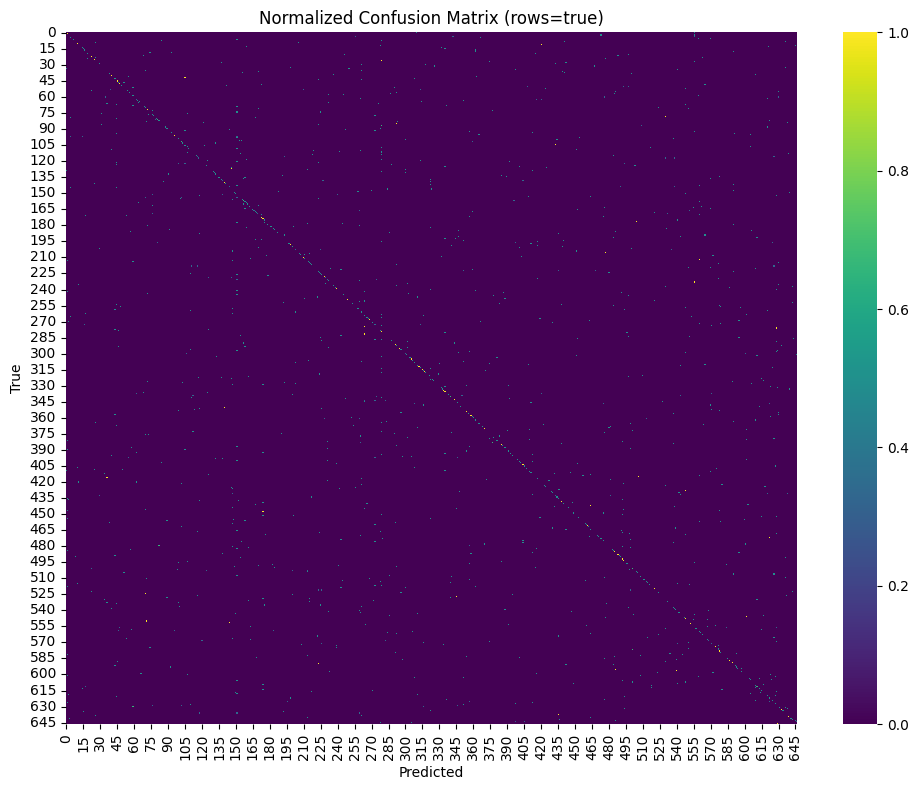

In [9]:
# === Cell F (new) — Evaluation, Plots and Test Report (robust worker handling) ===
"""
Find best checkpoint (prefixed), evaluate test set, plot and save train/val curves (if history found),
compute normalized confusion matrix for labels present, per-class accuracy, classification report (json/txt),
predictions CSV, and a JSON/TXT summary. Filenames prefixed with notebook stem + run_id.
This variant retries evaluation without multiprocessing if DataLoader worker processes die.
"""

import os, time, json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# dirs and prefix
ckpt_dir = ckpt_dir if 'ckpt_dir' in globals() else (Path('checkpoints'))
report_dir = Path('reports')
report_dir.mkdir(parents=True, exist_ok=True)
nb_stem = Path("06_train_baseline_3dCNN-r3d18_k400_kenetics-R(2+1)D-18-full.ipynb").stem
nb_prefix = str(nb_stem).replace(' ', '_')
if 'run_id' in globals():
    run_id_local = run_id
else:
    # try to infer run_id by scanning checkpoints for matching prefix
    candidates_scan = list(ckpt_dir.glob(f"{nb_prefix}_*_best_state.pt")) + list(ckpt_dir.glob(f"{nb_prefix}_*_best_full.pt"))
    if candidates_scan:
        # pick the most recent
        # sort by mtime
        candidates_scan = sorted(candidates_scan, key=lambda p: p.stat().st_mtime)
        chosen = candidates_scan[-1]
        # derive run_id from filename
        name = chosen.name
        # name like {nb_prefix}_{stamp}_best_state.pt -> extract the middle part
        suffix = f"{nb_prefix}_"
        if suffix in name and '_best_' in name:
            mid = name.split(suffix, 1)[1].split('_best_')[0]
            run_id_local = f"{nb_prefix}_{mid}"
        else:
            run_id_local = f"{nb_prefix}_{time.strftime('%Y%m%dT%H%M%S')}"
    else:
        run_id_local = f"{nb_prefix}_{time.strftime('%Y%m%dT%H%M%S')}"

run_id = run_id_local

# try to load history file if present (optional)
hist_candidates = [report_dir / f"{run_id}_history.json", report_dir / f"{nb_prefix}_history.json"]
history = None
for hp in hist_candidates:
    if hp.exists():
        try:
            with open(hp, 'r') as f:
                history = json.load(f)
            print('Loaded history from', hp)
            break
        except Exception:
            pass

if history is not None:
    epochs_ran = len(history.get('train_loss', []))
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    axs[0].plot(range(1, epochs_ran+1), history.get('train_loss', []), label='train')
    axs[0].plot(range(1, epochs_ran+1), history.get('val_loss', []), label='val')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()

    axs[1].plot(range(1, epochs_ran+1), history.get('train_acc', []), label='train')
    axs[1].plot(range(1, epochs_ran+1), history.get('val_acc', []), label='val')
    axs[1].set_title('Top-1 Accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend()

    plt.tight_layout()
    curves_path = report_dir / f"{run_id}_train_val_curves.png"
    plt.savefig(str(curves_path), dpi=150)
    display(fig)
else:
    print('No history found; skipping curves.')

# find best checkpoint
candidates = [
    ckpt_dir / f"{run_id}_best_state.pt",
    ckpt_dir / f"{run_id}_best_full.pt",
    ckpt_dir / f"{nb_prefix}_best_state.pt",
    ckpt_dir / f"{nb_prefix}_best_full.pt",
    ckpt_dir / 'best.pt',
]
best_path = None
for p in candidates:
    if p.exists():
        best_path = p
        break

if best_path is None:
    print('No checkpoint found among candidates:', candidates)
    print('Skipping evaluation.')
else:
    print('Loading checkpoint:', best_path)
    raw = torch.load(str(best_path), map_location=device if 'device' in globals() else 'cpu')

    state_dict = None
    if isinstance(raw, dict):
        if 'model_state' in raw:
            state_dict = raw['model_state']
        elif 'state_dict' in raw:
            state_dict = raw['state_dict']
        else:
            keys = list(raw.keys())
            if keys and isinstance(raw[keys[0]], (torch.Tensor,)):
                state_dict = raw
    else:
        state_dict = raw

    if state_dict is None:
        raise RuntimeError(f'Could not extract model parameters from {best_path}')

    # robust loading: direct, non-strict, remap prefixes, partial intersection
    def try_load(sd, strict=False):
        try:
            model.load_state_dict(sd, strict=strict)
            return True
        except Exception as e:
            print('load_state_dict error:', e)
            return False

    if not try_load(state_dict, strict=False):
        print('Direct load failed; attempting remapping...')
        mk = list(model.state_dict().keys())
        ck = list(state_dict.keys())

        def remap(sd, remove_prefix=None, add_prefix=None):
            out = {}
            for k, v in sd.items():
                nk = k
                if remove_prefix and nk.startswith(remove_prefix):
                    nk = nk[len(remove_prefix):]
                if add_prefix:
                    nk = add_prefix + nk
                out[nk] = v
            return out

        attempts = []
        if ck and ck[0].startswith('_orig_mod.'):
            attempts.append(remap(state_dict, remove_prefix='_orig_mod.'))
        if ck and ck[0].startswith('module.'):
            attempts.append(remap(state_dict, remove_prefix='module.'))
        if mk and mk[0].startswith('module.') and not (ck and ck[0].startswith('module.')):
            attempts.append(remap(state_dict, add_prefix='module.'))
        if mk and mk[0].startswith('_orig_mod.') and not (ck and ck[0].startswith('_orig_mod.')):
            attempts.append(remap(state_dict, add_prefix='_orig_mod.'))

        loaded = False
        for cand in attempts:
            if try_load(cand, strict=False):
                state_dict = cand
                loaded = True
                print('Loaded after remapping keys.')
                break

        if not loaded:
            # partial intersection
            print('Attempting partial intersection load...')
            model_sd = model.state_dict()
            intersect = {k: v for k, v in state_dict.items() if k in model_sd and v.shape == model_sd[k].shape}
            if not intersect:
                raise RuntimeError('No intersecting keys between checkpoint and model.')
            model.load_state_dict(intersect, strict=False)
            print('Partial load applied (intersection).')

    # move model to device
    if 'device' in globals():
        model.to(device)
    model.eval()

    # evaluate test set with robust fallback for DataLoader workers
    def evaluate_loader(loader):
        """
        Try forwarding inputs as-delivered by the DataLoader first (most datasets return [B, T, C, H, W]).
        If that fails with a channel/shape mismatch, attempt the permuted form [B, C, T, H, W].
        This avoids double-permuting when the model wrapper already permutes internally.
        """
        y_true = []
        y_pred = []
        paths = []
        losses = []
        for x, y, pth in tqdm(loader, desc='Evaluating test set'):
            x = x.to(device if 'device' in globals() else 'cpu', non_blocking=True)
            y = y.to(device if 'device' in globals() else 'cpu', non_blocking=True)

            logits = None
            loss = None

            # Try two attempts: 0) as-is (assumes dataset->model convention [B,T,C,H,W])
            # 1) permuted to [B,C,T,H,W] in case model expects channels-first input without internal permute
            for attempt in (0, 1):
                inp = x if attempt == 0 else x.permute(0, 2, 1, 3, 4).contiguous()
                try:
                    with torch.no_grad():
                        with torch.amp.autocast(device_type=device.type if 'device' in globals() else 'cpu', enabled=globals().get('AMP_ON', False)):
                            logits = model(inp)
                            loss = F.cross_entropy(logits, y)
                    # success
                    break
                except RuntimeError as e:
                    # Inspect message for channel/shape mismatch hints; if present, try the alternate ordering.
                    msg = str(e).lower()
                    if attempt == 0 and ("expected input" in msg or "channels" in msg or "but got" in msg or "shape" in msg):
                        # try permuted input on next loop iteration
                        continue
                    # otherwise re-raise — unexpected failure
                    raise

            if logits is None:
                raise RuntimeError('Model forward failed on both original and permuted inputs.')

            preds = logits.argmax(1)

            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            paths.extend(pth)
            losses.extend([float(loss.cpu().item())] * x.size(0))

        return np.array(y_true, dtype=int), np.array(y_pred, dtype=int), paths, np.array(losses, dtype=float)

    # First attempt with existing test_loader
    try:
        y_true, y_pred, paths, losses = evaluate_loader(test_loader)
    except RuntimeError as e:
        print('Evaluation failed with RuntimeError:', e)
        print('This often indicates a DataLoader worker crash. Retrying with num_workers=0...')
        # recreate a simple single-process DataLoader and retry
        try:
            batch_size = getattr(test_loader, 'batch_size', BATCH if 'BATCH' in globals() else 1)
            new_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
            y_true, y_pred, paths, losses = evaluate_loader(new_loader)
            print('Retry with num_workers=0 succeeded.')
        except Exception as e2:
            print('Retry also failed:', e2)
            raise

    test_acc = float((y_true == y_pred).mean())
    print(f'Test Top-1 accuracy: {test_acc:.4f} (N={len(y_true)})')

    # label->gloss mapping (use df which is present in this notebook)
    label_to_name = None
    if 'df' in globals() and 'gloss' in df.columns and 'label_new' in df.columns:
        tmp = df.groupby('label_new')['gloss'].first().to_dict()
        label_to_name = {int(k): str(v) for k, v in tmp.items()}

    # present labels
    present = sorted(set(np.unique(y_true)).union(set(np.unique(y_pred))))
    labels_list = [int(x) for x in present]
    names_list = [label_to_name.get(int(l), str(int(l))) if label_to_name is not None else str(int(l)) for l in labels_list]

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels_list)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)

    fig, ax = plt.subplots(figsize=(10, 8))
    if len(labels_list) <= 50:
        sns.heatmap(cm_norm, xticklabels=names_list, yticklabels=names_list, cmap='viridis', vmin=0, vmax=1, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    else:
        sns.heatmap(cm_norm, cmap='viridis', vmin=0, vmax=1, ax=ax)
    ax.set_title('Normalized Confusion Matrix (rows=true)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.tight_layout()
    cm_path = report_dir / f"{run_id}_confusion_matrix_norm.png"
    plt.savefig(str(cm_path), dpi=150)
    display(fig)

    # per-class accuracy
    support = cm.sum(axis=1)
    per_class_acc = (cm.diagonal().astype('float') / (support + 1e-12))
    class_acc_df = pd.DataFrame({
        'label': labels_list,
        'gloss': names_list,
        'accuracy': per_class_acc,
        'support': support
    })
    class_acc_df = class_acc_df.sort_values('accuracy', ascending=False).reset_index(drop=True)

    display(class_acc_df.head(20))
    per_class_csv = report_dir / f"{run_id}_per_class_accuracy.csv"
    class_acc_df.to_csv(str(per_class_csv), index=False)

    # classification report
    clf_report_dict = classification_report(y_true, y_pred, labels=labels_list, target_names=names_list, zero_division=0, output_dict=True)
    clf_report_txt = classification_report(y_true, y_pred, labels=labels_list, target_names=names_list, zero_division=0)

    clf_json_path = report_dir / f"{run_id}_classification_report.json"
    with open(str(clf_json_path), 'w') as f:
        json.dump(clf_report_dict, f, indent=2)

    clf_txt_path = report_dir / f"{run_id}_classification_report.txt"
    with open(str(clf_txt_path), 'w') as f:
        f.write(clf_report_txt)

    print('\nSaved classification report (json & txt) at:', clf_json_path, clf_txt_path)

    # predictions CSV
    preds_df = pd.DataFrame({'path': paths, 'y_true': y_true.tolist(), 'y_pred': y_pred.tolist()})
    if label_to_name is not None:
        preds_df['y_true_name'] = preds_df['y_true'].map(lambda x: label_to_name.get(int(x), str(int(x))))
        preds_df['y_pred_name'] = preds_df['y_pred'].map(lambda x: label_to_name.get(int(x), str(int(x))))
    else:
        preds_df['y_true_name'] = preds_df['y_true'].astype(str)
        preds_df['y_pred_name'] = preds_df['y_pred'].astype(str)

    preds_csv = report_dir / f"{run_id}_predictions.csv"
    preds_df.to_csv(str(preds_csv), index=False)

    # assemble report
    report = {
        'created_at': time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()),
        'notebook': nb_prefix,
        'run_id': run_id,
        'best_checkpoint': str(best_path),
        'test_top1': float(test_acc),
        'n_samples': int(len(y_true)),
        'num_classes_present': int(len(labels_list)),
        'per_class_csv': str(per_class_csv),
        'confusion_matrix_png': str(cm_path),
        'classification_report_json': str(clf_json_path),
        'predictions_csv': str(preds_csv)
    }

    test_report_json = report_dir / f"{run_id}_test_report.json"
    with open(str(test_report_json), 'w') as f:
        json.dump(report, f, indent=2)

    test_report_txt = report_dir / f"{run_id}_test_report.txt"
    with open(str(test_report_txt), 'w') as f:
        f.write('Test report\n')
        f.write('Created: ' + report['created_at'] + '\n')
        f.write('Notebook: ' + report['notebook'] + '\n')
        f.write('Run: ' + report['run_id'] + '\n')
        f.write('Checkpoint: ' + report['best_checkpoint'] + '\n')
        f.write(f"Test Top1: {report['test_top1']} (N={report['n_samples']})\n")
        f.write(f"Num classes present: {report['num_classes_present']}\n")

    print('\nSaved test report JSON and TXT to', test_report_json, test_report_txt)
